# EPSM AI Workshop: Part 2

## Making it really work in practice- Data cleaning and set-up for imaging data

Contact Phillip Chlap: [phillip.chlap@unsw.edu.au](phillip.chlap@unsw.edu.au)

Within this session we'll explore working with real-world Radiotherapy DICOM data and how to clean it up and convert it to a form more suitable to use in in our AI projects.

## Python Libraries

To accomplish our goal within this session we will make use of the following open-source Python libraries:
- pydicom: https://pydicom.github.io/pydicom
- pandas: https://pandas.pydata.org/
- SimpleITK: https://simpleitk.readthedocs.io/
- platipy: https://pyplati.github.io/platipy/

### Install Libraries

Let's install these now using Python's builtin package manager `pip`.

In [1]:
!pip install pydicom
!pip install SimpleITK
!pip install textdistance
!pip install platipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 4.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 52.8 MB 152 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.2 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 
     |████████████████████████████████| 1.6 MB 33.1 MB/s 
     |████████████████████████████████| 96 kB 6.0 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7

### Import Libraries

Now that they are installed, we must import the specific modules and functions which we plan to use throughout the session.

In [2]:
from pathlib import Path
import shutil
from datetime import datetime

import pydicom
import pandas as pd
import SimpleITK as sitk
import textdistance
from tqdm import tqdm

from platipy.imaging import ImageVisualiser
from platipy.imaging.tests.data import download_and_extract_zip_file
from platipy.dicom.io.rtstruct_to_nifti import convert_rtstruct

## Working with DICOM data

### Fetching sample data

Next we need some data to work with. In this example we'll be using Radiotherapy DICOM data from [The Cancer Imaging Archive (TCIA)](https://www.cancerimagingarchive.net/). A portion of this has been prepared in a zip file stored on Zenodo.

In [3]:
dicom_zip_url = "https://zenodo.org/record/5276878/files/HNSCC.zip"
download_and_extract_zip_file(dicom_zip_url, "dicom")

### Exploring the DICOM data

In the 'Files' section to the left, you should now see a directory called `dicom`. Within this File Explorer you can navigate your way through these files to see what's available.

DICOM files can be difficult to work with on the file system since their name are often not particularly descriptive. Fortunately we have a file describing the files we have in this dataset, see `metadata.csv`.

Let's use the pandas library to read this file in our code

In [4]:
dicom_path = Path("dicom")
df = pd.read_csv(dicom_path.joinpath("HNSCC", "metadata.csv"))
df

,Series UID,Collection,3rd Party Analysis,Data Description URI,Subject ID,Study UID,Study Description,Study Date,Series Description,Manufacturer,Modality,SOP Class Name,SOP Class UID,Number of Images,File Size,File Location,Download Timestamp
0,1.3.6.1.4.1.14519.5.2.1.1706.8040.202542618630...,HNSCC,NaN,httpsdoi.org10.7937k9tcia.2020.a8sh-7363,HNSCC-01-0019,1.3.6.1.4.1.14519.5.2.1.1706.8040.797724702538...,RT SIMULATION,07-04-1998,NaN,ADAC,RTPLAN,RT Plan Storage,1.2.840.10008.5.1.4.1.1.481.5,1,166.27 KB,./HNSCC/HNSCC-01-0019/07-04-1998-NA-RT SIMULAT...,2021-08-27T08:58:05.249
1,1.3.6.1.4.1.14519.5.2.1.1706.8040.777975715563...,HNSCC,NaN,httpsdoi.org10.7937k9tcia.2020.a8sh-7363,HNSCC-01-0019,1.3.6.1.4.1.14519.5.2.1.1706.8040.797724702538...,RT SIMULATION,07-04-1998,NaN,ADAC,RTDOSE,RT Dose Storage,1.2.840.10008.5.1.4.1.1.481.2,1,1.35 MB,./HNSCC/HNSCC-01-0019/07-04-1998-NA-RT SIMULAT...,2021-08-27T08:58:08.487
2,1.3.6.1.4.1.14519.5.2.1.1706.8040.103450757970...,HNSCC,NaN,httpsdoi.org10.7937k9tcia.2020.a8sh-7363,HNSCC-01-0019,1.3.6.1.4.1.14519.5.2.1.1706.8040.797724702538...,RT SIMULATION,07-04-1998,NaN,ADAC,RTSTRUCT,RT Structure Set Storage,1.2.840.10008.5.1.4.1.1.481.3,1,6.13 MB,./HNSCC/HNSCC-01-0019/07-04-1998-NA-RT SIMULAT...,2021-08-27T08:58:08.771
3,1.3.6.1.4.1.14519.5.2.1.1706.8040.176143398282...,HNSCC,NaN,httpsdoi.org10.7937k9tcia.2020.a8sh-7363,HNSCC-01-0176,1.3.6.1.4.1.14519.5.2.1.1706.8040.112774805040...,CT HEAD NECK WCON,03-05-2004,BONE,GE MEDICAL SYSTEMS,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,40,21.14 MB,./HNSCC/HNSCC-01-0176/03-05-2004-NA-CT HEAD N...,2021-08-27T08:58:28.312
4,1.3.6.1.4.1.14519.5.2.1.1706.8040.275221863632...,HNSCC,NaN,httpsdoi.org10.7937k9tcia.2020.a8sh-7363,HNSCC-01-0176,1.3.6.1.4.1.14519.5.2.1.1706.8040.112774805040...,CT HEAD NECK WCON,03-05-2004,SCOUTNECK-ORALNASO WCON,GE MEDICAL SYSTEMS,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,2,2.94 MB,./HNSCC/HNSCC-01-0176/03-05-2004-NA-CT HEAD N...,2021-08-27T08:58:34.311
5,1.3.6.1.4.1.14519.5.2.1.1706.8040.192899726585...,HNSCC,NaN,httpsdoi.org10.7937k9tcia.2020.a8sh-7363,HNSCC-01-0176,1.3.6.1.4.1.14519.5.2.1.1706.8040.112774805040...,CT HEAD NECK WCON,03-05-2004,ANGLES,GE MEDICAL SYSTEMS,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,40,21.14 MB,./HNSCC/HNSCC-01-0176/03-05-2004-NA-CT HEAD N...,2021-08-27T08:58:34.725
6,1.3.6.1.4.1.14519.5.2.1.1706.8040.233510441938...,HNSCC,NaN,httpsdoi.org10.7937k9tcia.2020.a8sh-7363,HNSCC-01-0019,1.3.6.1.4.1.14519.5.2.1.1706.8040.797724702538...,RT SIMULATION,07-04-1998,NaN,Philips,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,131,69.05 MB,./HNSCC/HNSCC-01-0019/07-04-1998-NA-RT SIMULAT...,2021-08-27T08:58:44.289
7,1.3.6.1.4.1.14519.5.2.1.1706.8040.151938046710...,HNSCC,NaN,httpsdoi.org10.7937k9tcia.2020.a8sh-7363,HNSCC-01-0176,1.3.6.1.4.1.14519.5.2.1.1706.8040.120307635397...,NaN,03-01-2009,NaN,GE MEDICAL SYSTEMS,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,135,71.05 MB,./HNSCC/HNSCC-01-0176/03-01-2009-NA-NA-44207/1...,2021-08-27T08:59:55.044
8,1.3.6.1.4.1.14519.5.2.1.1706.8040.276897558084...,HNSCC,NaN,httpsdoi.org10.7937k9tcia.2020.a8sh-7363,HNSCC-01-0176,1.3.6.1.4.1.14519.5.2.1.1706.8040.120307635397...,RT SIMULATION,03-01-2009,NaN,ADAC,RTSTRUCT,RT Structure Set Storage,1.2.840.10008.5.1.4.1.1.481.3,1,7.10 MB,./HNSCC/HNSCC-01-0176/03-01-2009-NA-RT SIMULAT...,2021-08-27T09:00:14.777
9,1.3.6.1.4.1.14519.5.2.1.1706.8040.279793773343...,HNSCC,NaN,httpsdoi.org10.7937k9tcia.2020.a8sh-7363,HNSCC-01-0176,1.3.6.1.4.1.14519.5.2.1.1706.8040.120307635397...,RT SIMULATION,03-01-2009,NaN,ADAC,RTDOSE,RT Dose Storage,1.2.840.10008.5.1.4.1.1.481.2,1,2.13 MB,./HNSCC/HNSCC-01-0176/03-01-2009-NA-RT SIMULAT...,2021-08-27T09:00:18.179


### Reading DICOM data

We can use the pydicom library to open the RTSTRUCT file and inspect it

In [5]:
rtstruct_row = df[(df["Subject ID"] == "HNSCC-01-0019") & (df["Modality"] == "RTSTRUCT")].iloc[0]
rtstruct_dir = dicom_path.joinpath(rtstruct_row["File Location"])
rtstruct_file = list(rtstruct_dir.glob("*"))[0]

print(f"Reading RTSTRUCT file at {rtstruct_file}")
rtstruct = pydicom.read_file(rtstruct_file)

Reading RTSTRUCT file at dicom/HNSCC/HNSCC-01-0019/07-04-1998-NA-RT SIMULATION-48452/1.000000-NA-10361/1-1.dcm


In [6]:
# List the attributes present in the dataset
rtstruct.dir()

['AccessionNumber',
 'ApprovalStatus',
 'BodyPartExamined',
 'DeidentificationMethod',
 'DeidentificationMethodCodeSequence',
 'InstanceCreationDate',
 'InstanceCreationTime',
 'LongitudinalTemporalInformationModified',
 'Manufacturer',
 'ManufacturerModelName',
 'Modality',
 'PatientBirthDate',
 'PatientID',
 'PatientIdentityRemoved',
 'PatientName',
 'PatientSex',
 'ROIContourSequence',
 'RTROIObservationsSequence',
 'ReferencedFrameOfReferenceSequence',
 'ReferencedStudySequence',
 'ReferringPhysicianName',
 'SOPClassUID',
 'SOPInstanceUID',
 'SeriesInstanceUID',
 'SeriesNumber',
 'SoftwareVersions',
 'SpecificCharacterSet',
 'StructureSetDate',
 'StructureSetLabel',
 'StructureSetName',
 'StructureSetROISequence',
 'StructureSetTime',
 'StudyDate',
 'StudyDescription',
 'StudyID',
 'StudyInstanceUID',
 'StudyTime']

In [7]:
# Output the Structure Set Name
rtstruct.StructureSetName

'POIandROIandBOLUS'

In [8]:
# Loop over and print the names of the structures available
for struct_seq in rtstruct.StructureSetROISequence:
  print(struct_seq.ROIName)

Marked Iso
Calc pt
External
GTV1
RT Parotid
LT Parotid
Brainstem
Cord
Optic Nerve
CTV70
CTV63
ctv 57
larynx avoidance
chiasm
CTV63 Sep
Brain
Mandible
PTV70
PTV63
PTV57
+1
-.3
Ring
Post Neck
Oral Avoid
Rt Sup Prtd
Rt Deep Prtd
Lt Sup Prtd
Lt Deep Prtd
Cord_EXPANDED
hotspot
cool off
cold
cold hot


### Manipulating DICOM data

pydicom also allows us to modify the DICOM files. This can often be useful when to correct issues in the header attributes.

In this example, we want to rename the `Cord` structure to the TG-263 recommended name `SpinalCord`

In [12]:
# Loop over and change the name Cord to SpinalCord
for struct_seq in rtstruct.StructureSetROISequence:
  # print(struct_seq)
  if struct_seq.ROIName == "Cord":
    print(f"Renaming {struct_seq.ROIName} to SpinalCord")
    struct_seq.ROIName = "SpinalCord"
  if struct_seq.ROIName == "ctv 57":
    print(f"Renaming {struct_seq.ROIName} to CTV57")
    struct_seq.ROIName = "CTV57"
# And overwrite the DICOM file
rtstruct.save_as(rtstruct_file)

Renaming ctv 57 to CTV57


### Exercise

Try changing the StructureSetName and save the DICOM file. You might also like to manipulate some other DICOM header attributes.

In [16]:
# First modify the Structure Set Name
rtstruct.StructureSetName = 'POIandROIandBOLUS1'
print(rtstruct.StructureSetName)
rtstruct.StructureSetName = 'POIandROIandBOLUS'
print(rtstruct.StructureSetName)

# Then Overwrite the DICOM file
rtstruct.save_as(rtstruct_file)

POIandROIandBOLUS1
POIandROIandBOLUS


In [17]:
# Now we'll reload the DICOM file from the disk and check that our changes are there
rtstruct = pydicom.read_file(rtstruct_file)

In [18]:
rtstruct.StructureSetName

'POIandROIandBOLUS'

In [19]:
for struct_seq in rtstruct.StructureSetROISequence:
  print(struct_seq.ROIName)

Marked Iso
Calc pt
External
GTV1
RT Parotid
LT Parotid
Brainstem
SpinalCord
Optic Nerve
CTV70
CTV63
CTV57
larynx avoidance
chiasm
CTV63 Sep
Brain
Mandible
PTV70
PTV63
PTV57
+1
-.3
Ring
Post Neck
Oral Avoid
Rt Sup Prtd
Rt Deep Prtd
Lt Sup Prtd
Lt Deep Prtd
Cord_EXPANDED
hotspot
cool off
cold
cold hot


## Converting DICOM data

The DICOM format is ubiquitous in the medical image domain and has proven itself particularly useful to store and transfer images within hospitals and clincs. However it is not necessarily well suited to work with in AI projects so converting DICOM data to other formats is often desirable.

Many different image formats exist which can be more easily utilised in AI projects. In this session we will convert our data to NIfTI format. Originally designed for use in neuroimaging, this format allows storing of 3D image volumes while preserving the pixel (voxel) spacing and frame of reference.

The SimpleITK library is able to easily work with Image volumes stored in NIfTI. Here we define a function which will allow us to convert our DICOM image volumes to a SimpleITK image. Then we can save it off using the NIfTI format.

In [20]:
def read_dicom_image_to_sitk(img_path):
  reader = sitk.ImageSeriesReader()

  dicom_names = reader.GetGDCMSeriesFileNames(str(img_path))
  reader.SetFileNames(dicom_names)

  image = reader.Execute()

  return image

### Convert CT Image

Here we'll load a CT image using SimpleITK and then save it in NIfTI format.

> Tip: The file extension `.nii` informs SimpleITK to use the NIfTI format. It's advised to always expand that to `.nii.gz` to inform SimpleITK to also GZip the file, compressing it and making it much smaller on disk.

In [21]:
# Define a directory where to store converted data
subject = "HNSCC-01-0019"
converted_dir = Path("./converted")
patient_converted_dir = converted_dir.joinpath(subject)
patient_converted_dir.mkdir(exist_ok=True, parents=True)

ct_row = df[(df["Subject ID"] == subject) & (df["Modality"] == "CT")].iloc[0]
ct_directory = dicom_path.joinpath(ct_row["File Location"])
ct_image = read_dicom_image_to_sitk(ct_directory)

output_file = patient_converted_dir.joinpath("CT.nii.gz")
sitk.WriteImage(ct_image, str(output_file))

### Convert RT Structure Set

Within the DICOM RTSTRUCT modality, structures are stored as a set of contour points within the header attributes. This is particularly difficult to use in AI projects. Here we will convert the structures available using the PlatiPy library to a set of binary masks and save those in NIfTI format.

The `convert_rtstruct` function takes the DICOM CT image and the corresponding DICOM RTSTRUCT file. The structures will be convereted in the image space of the CT image.

In [22]:
rtstruct_row = df[(df["Subject ID"] == "HNSCC-01-0019") & (df["Modality"] == "RTSTRUCT")].iloc[0]
rtstruct_dir = dicom_path.joinpath(rtstruct_row["File Location"])
rtstruct_file = list(rtstruct_dir.glob("*"))[0]

convert_rtstruct(ct_directory, rtstruct_file, output_dir=patient_converted_dir)

### Visualise the data

In the file explorer, navigate to `converted/HNSCC-01-0019` to view our converted files. When working on our local computer, we could now easily open these in a tool like 3D Slicer. But in some scenarios we can't access that tool or want to have a faster way to view the data.

Let's use the `ImageVisualiser` class in PlatiPy to view and save a cross-section of the data we converted.

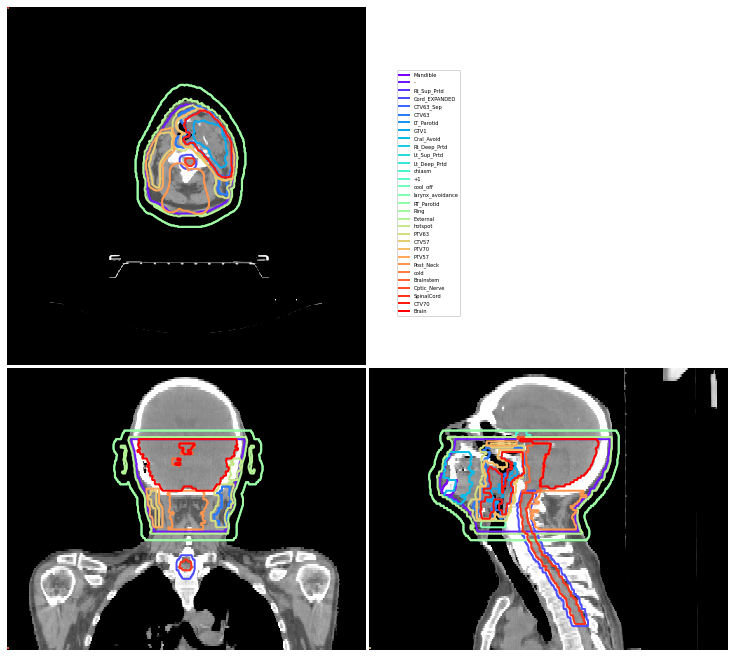

In [24]:
vis = ImageVisualiser(ct_image)
contours = {
    s.name.split(".")[0].replace("Struct_", ""): sitk.ReadImage(str(s)) 
    for s in patient_converted_dir.glob("Struct_*.nii.gz")}
  
vis.add_contour(contours)
fig = vis.show()
output_file_path = patient_converted_dir.joinpath("visualisation.pdf")
fig.savefig(output_file_path, dpi=fig.dpi)

### Bulk conversion of data

So far we have converted the Image and Structures for one patient. In practice we would like to write a script to convert all our DICOM data at once. Let's put it all together and run this across all 3 patients in one go.

On closer inspection of our data, we can see that for the `HNSCC-01-0019` patient we only have one image and one structure set. Here there was no ambiguity as to which image and structure to use.

In practice, our data is rarely that clean. As is the case for patient `HNSCC-01-0176` we need to implement some logic to select the CT image and structure set that we want for that patient.

In [25]:
selected_rows = []
for pat, df_group in df.groupby("Subject ID"):

  # Select the structure set with the later date
  latest_date = None
  latest_file = None
  linked_ct_uid = None
  for idx, rtstruct_row in df_group[df_group.Modality == "RTSTRUCT"].iterrows():
    rtstruct_dir = dicom_path.joinpath(rtstruct_row["File Location"])
    rtstruct_file = list(rtstruct_dir.glob("*"))[0]

    rtstruct = pydicom.read_file(rtstruct_file)
    rtstruct_date = int(rtstruct.InstanceCreationDate)

    if latest_date is None or rtstruct_date > latest_date:
      latest_date = rtstruct_date
      latest_file = idx
      linked_ct_uid = rtstruct.ReferencedFrameOfReferenceSequence[0].RTReferencedStudySequence[0].RTReferencedSeriesSequence[0].SeriesInstanceUID
  
  # Select the RTSTRUCT for this patient
  selected_rows.append(latest_file)

  # Also select the CT image linked to the RTSTRUCT
  ct_idx = df[df["Series UID"] == linked_ct_uid].iloc[0].name
  selected_rows.append(ct_idx)

df_clean = df.loc[selected_rows]

Let's have a look at our cleaned up dataset in `df_clean`. This should now hold the one CT and one RTSTRUCT selected for each patient.

In [26]:
df_clean

,Series UID,Collection,3rd Party Analysis,Data Description URI,Subject ID,Study UID,Study Description,Study Date,Series Description,Manufacturer,Modality,SOP Class Name,SOP Class UID,Number of Images,File Size,File Location,Download Timestamp
2,1.3.6.1.4.1.14519.5.2.1.1706.8040.103450757970...,HNSCC,NaN,httpsdoi.org10.7937k9tcia.2020.a8sh-7363,HNSCC-01-0019,1.3.6.1.4.1.14519.5.2.1.1706.8040.797724702538...,RT SIMULATION,07-04-1998,NaN,ADAC,RTSTRUCT,RT Structure Set Storage,1.2.840.10008.5.1.4.1.1.481.3,1,6.13 MB,./HNSCC/HNSCC-01-0019/07-04-1998-NA-RT SIMULAT...,2021-08-27T08:58:08.771
6,1.3.6.1.4.1.14519.5.2.1.1706.8040.233510441938...,HNSCC,NaN,httpsdoi.org10.7937k9tcia.2020.a8sh-7363,HNSCC-01-0019,1.3.6.1.4.1.14519.5.2.1.1706.8040.797724702538...,RT SIMULATION,07-04-1998,NaN,Philips,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,131,69.05 MB,./HNSCC/HNSCC-01-0019/07-04-1998-NA-RT SIMULAT...,2021-08-27T08:58:44.289
14,1.3.6.1.4.1.14519.5.2.1.1706.8040.495627765798...,HNSCC,NaN,httpsdoi.org10.7937k9tcia.2020.a8sh-7363,HNSCC-01-0176,1.3.6.1.4.1.14519.5.2.1.1706.8040.185550155490...,NaN,03-01-2009,NaN,ADAC,RTSTRUCT,RT Structure Set Storage,1.2.840.10008.5.1.4.1.1.481.3,1,4.65 MB,./HNSCC/HNSCC-01-0176/03-01-2009-NA-NA-47813/1...,2021-08-27T09:02:14.844
19,1.3.6.1.4.1.14519.5.2.1.1706.8040.244362210503...,HNSCC,NaN,httpsdoi.org10.7937k9tcia.2020.a8sh-7363,HNSCC-01-0176,1.3.6.1.4.1.14519.5.2.1.1706.8040.185550155490...,RT SIMULATION,03-01-2009,NaN,GE MEDICAL SYSTEMS,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,165,86.85 MB,./HNSCC/HNSCC-01-0176/03-01-2009-NA-RT SIMULAT...,2021-08-27T09:02:40.294
18,1.3.6.1.4.1.14519.5.2.1.1706.8040.243934637013...,HNSCC,NaN,httpsdoi.org10.7937k9tcia.2020.a8sh-7363,HNSCC-01-0199,1.3.6.1.4.1.14519.5.2.1.1706.8040.756832291630...,RT SIMULATION,10-26-2002,NaN,ADAC,RTSTRUCT,RT Structure Set Storage,1.2.840.10008.5.1.4.1.1.481.3,1,5.78 MB,./HNSCC/HNSCC-01-0199/10-26-2002-NA-RT SIMULAT...,2021-08-27T09:02:32.671
20,1.3.6.1.4.1.14519.5.2.1.1706.8040.261759476368...,HNSCC,NaN,httpsdoi.org10.7937k9tcia.2020.a8sh-7363,HNSCC-01-0199,1.3.6.1.4.1.14519.5.2.1.1706.8040.756832291630...,RT SIMULATION,10-26-2002,NaN,Philips,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,174,91.80 MB,./HNSCC/HNSCC-01-0199/10-26-2002-NA-RT SIMULAT...,2021-08-27T09:03:35.474


Now we can loop over this data and convert it all at once

/usr/local/lib/python3.7/dist-packages/platipy/imaging/visualisation/visualiser.py:1139: UserWarning: No contour levels were found within the data range.
  origin={"normal": "upper", "reversed": "lower"}[self.__origin],


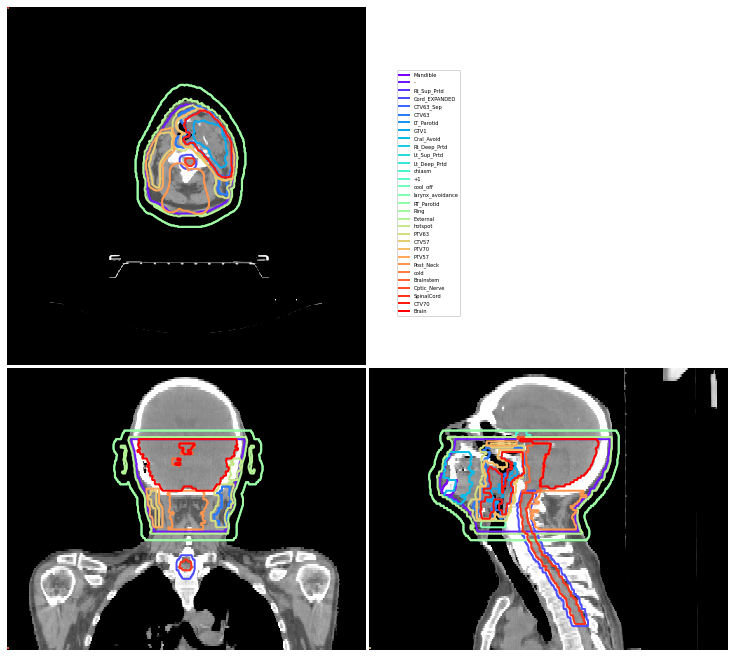

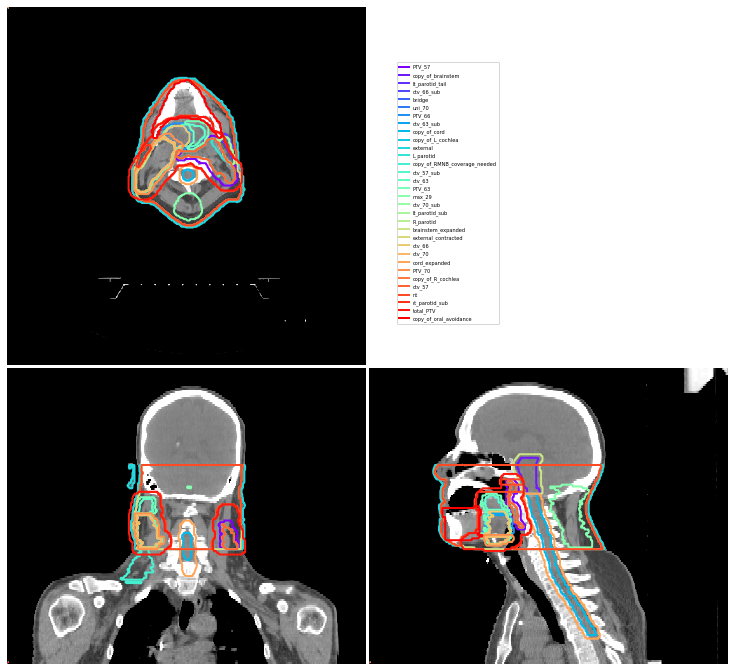

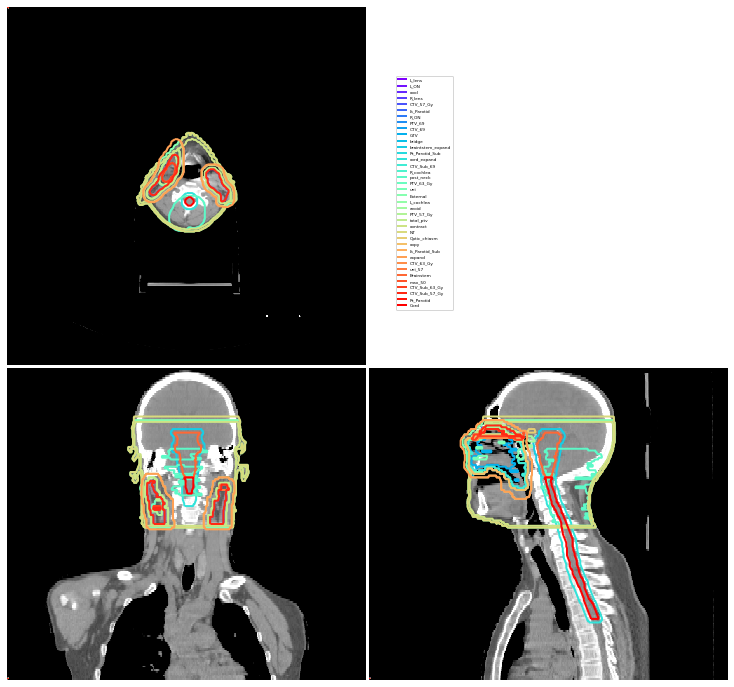

In [27]:
converted_dir = Path("./converted")
for subject, df_pat in df_clean.groupby("Subject ID"):

  # Create the patient directory
  patient_converted_dir = converted_dir.joinpath(subject)
  patient_converted_dir.mkdir(exist_ok=True, parents=True)

  # Convert the CT Image
  ct_row = df_pat[df_pat["Modality"] == "CT"].iloc[0]
  ct_directory = dicom_path.joinpath(ct_row["File Location"])
  ct_image = read_dicom_image_to_sitk(ct_directory)
  output_file = patient_converted_dir.joinpath("CT.nii.gz")
  sitk.WriteImage(ct_image, str(output_file))

  # Convert the Structures
  rtstruct_row = df_pat[df_pat["Modality"] == "RTSTRUCT"].iloc[0]
  rtstruct_dir = dicom_path.joinpath(rtstruct_row["File Location"])
  rtstruct_file = list(rtstruct_dir.glob("*"))[0]
  convert_rtstruct(ct_directory, rtstruct_file, output_dir=patient_converted_dir)

  # Prepare and save the visualisation
  vis = ImageVisualiser(ct_image)
  contours = {s.name.split(".")[0].replace("Struct_", ""): sitk.ReadImage(str(s)) for s in patient_converted_dir.glob("Struct_*.nii.gz")}
  vis.add_contour(contours)
  fig = vis.show()
  output_file_path = patient_converted_dir.joinpath("visualisation.png")
  fig.savefig(output_file_path, dpi=fig.dpi)

We can now browse our converted files for the 3 patients within the `converted` directory. We can look at the `visualisation.png` file for a quick snapshot of the data.

The next thing you'll notice is that there are many structures which we may not be interested in. In addition these structures aren't consistently names between the dataset. In the final section of this session we will look at how we might pick the structures we would like to use to train an auto-segmentation algorithm.

## Structure name standardisaton

In real-world data we will often see that structure names aren't not consistently defined in the DICOM data. TG-263 was recently released to help resolve this issue, however it is not adopted by all departments. In this section we will define the TG-263 name of the structures we would like to use to train an auto-segmentation algorithm and use the Python package `textdistance` to attempt to automatically select these in our dataset.

In [28]:
tg_263_structure_names = [
    "Parotid_L",
    "Parotid_R",
    "Brainstem",
    "External"
  ]

### Determine structure names in our dataset

First let's inspect all the different structure names we have in our dataset.

In [29]:
patient_directories = list(converted_dir.glob("*"))

patient_structures = {}
for pat_dir in patient_directories:

  pat = pat_dir.name
  print(f"Patient: {pat}")
  
  structures = [s.name.replace("Struct_", "").replace(".nii.gz", "") for s in pat_dir.glob("Struct_*.nii.gz")]
  print(structures)
  patient_structures[pat] = structures
  print("-----")

Patient: HNSCC-01-0176
['PTV_57', 'copy_of_brainstem', 'lt_parotid_tail', 'ctv_66_sub', 'bridge', 'uni_70', 'PTV_66', 'ctv_63_sub', 'copy_of_cord', 'copy_of_L_cochlea', 'external', 'L_parotid', 'copy_of_RMNB_coverage_needed', 'ctv_57_sub', 'ctv_63', 'PTV_63', 'max_29', 'ctv_70_sub', 'lt_parotid_sub', 'R_parotid', 'brainstem_expanded', 'external_contracted', 'ctv_66', 'ctv_70', 'cord_expanded', 'PTV_70', 'copy_of_R_cochlea', 'ctv_57', 'nt', 'rt_parotid_sub', 'total_PTV', 'copy_of_oral_avoidance']
-----
Patient: HNSCC-01-0199
['L_lens', 'L_ON', 'cool', 'R_lens', 'CTV_57_Gy', 'Lt_Parotid', 'R_ON', 'PTV_69.96_Gy', 'CTV_69.96_Gy', 'GTV', 'bridge', 'braintstem_expand', 'Rt_Parotid_Sub', 'cord_expand', 'CTV_Sub_69.96_Gy', 'R_cochlea', 'post_neck', 'PTV_63_Gy', 'uni', 'External', 'L_cochlea', 'avoid', 'PTV_57_Gy', 'total_ptv', 'contract', 'NT', 'Optic_chiasm', 'copy', 'Lt_Parotid_Sub', 'expand', 'CTV_63_Gy', 'uni_57', 'Brainstem', 'max_50', 'CTV_Sub_63_Gy', 'CTV_Sub_57_Gy', 'Rt_Parotid', 'Cord

### Match to standardised names

Here we use the Jaccard method of scoring how well the different structure names match the TG-263 standard name. We then select the structure with the highest score per patient.

In [30]:
selected_pat_structures = {}
for pat in patient_structures:
  
  structure_names = patient_structures[pat]
  df_structures = pd.DataFrame(index=structure_names, columns=tg_263_structure_names)
  df_structures = df_structures.apply(lambda col: [textdistance.jaccard.similarity(col.name, x) for x in col.index])

  print(f"Patient: {pat}")
  selected_structures = df_structures.idxmax()
  selected_pat_structures[pat] = selected_structures
  print(selected_structures)
  print("-----")


Patient: HNSCC-01-0176
Parotid_L            L_parotid
Parotid_R            R_parotid
Brainstem    copy_of_brainstem
External              external
dtype: object
-----
Patient: HNSCC-01-0199
Parotid_L    Lt_Parotid
Parotid_R    Rt_Parotid
Brainstem     Brainstem
External       External
dtype: object
-----
Patient: HNSCC-01-0019
Parotid_L    LT_Parotid
Parotid_R    RT_Parotid
Brainstem     Brainstem
External       External
dtype: object
-----


In [35]:
df_structures


,Parotid_L,Parotid_R,Brainstem,External
Mandible,0.214286,0.214286,0.307692,0.333333
-.3,0.000000,0.000000,0.000000,0.000000
Rt_Sup_Prtd,0.333333,0.428571,0.111111,0.117647
Cord_EXPANDED,0.294118,0.294118,0.047619,0.105263
CTV63_Sep,0.058824,0.058824,0.058824,0.062500
CTV63,0.000000,0.000000,0.000000,0.000000
LT_Parotid,0.900000,0.727273,0.266667,0.200000
GTV1,0.000000,0.000000,0.000000,0.000000
Oral_Avoid,0.461538,0.461538,0.187500,0.200000
Rt_Deep_Prtd,0.312500,0.400000,0.166667,0.176471


In [34]:
selected_structures

Parotid_L    LT_Parotid
Parotid_R    RT_Parotid
Brainstem     Brainstem
External       External
dtype: object

### Select Cleaned Structures

Let's create a new directory to hold the clean data.

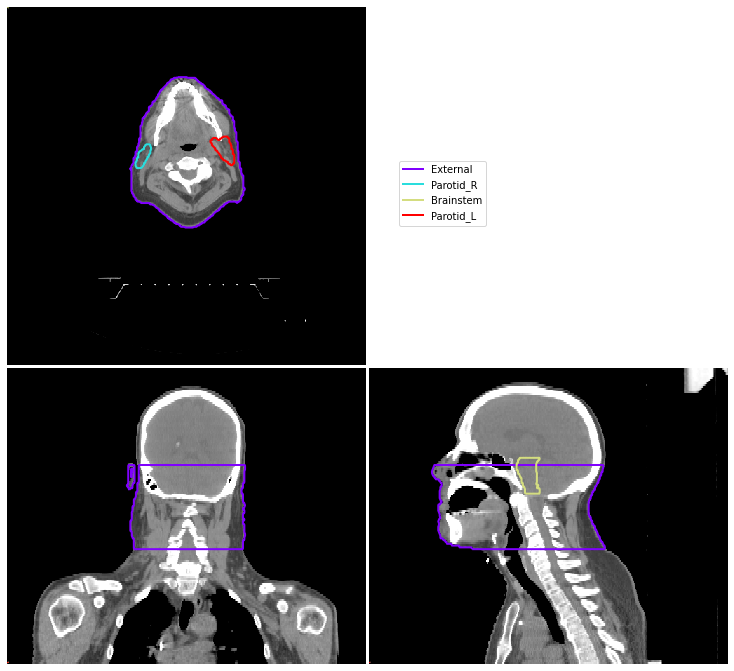

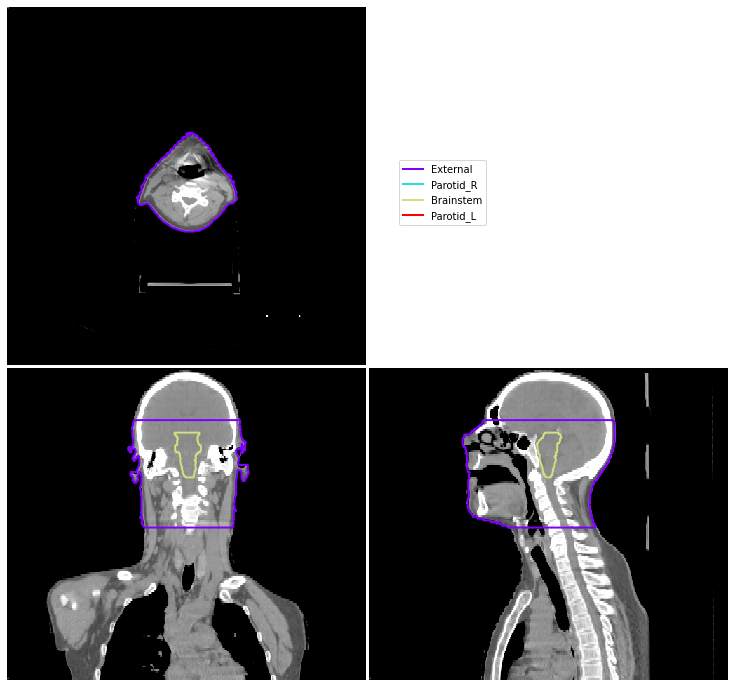

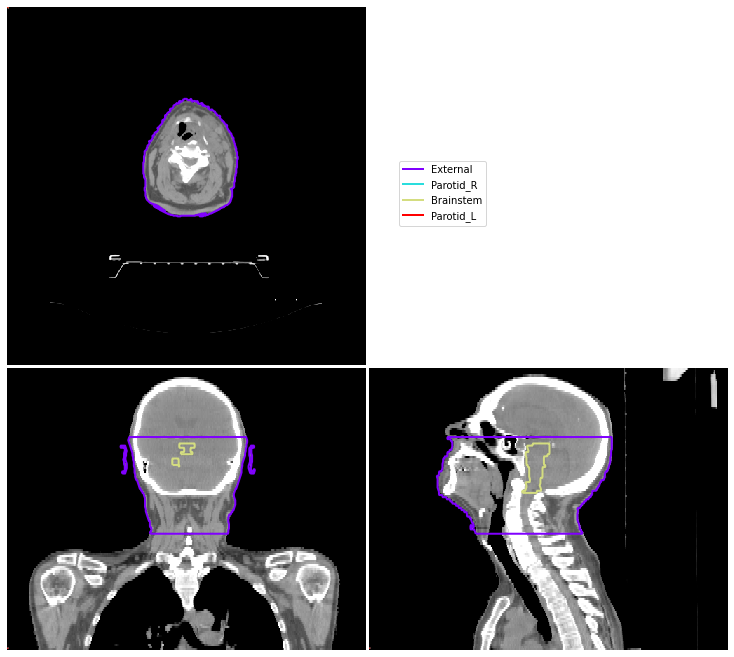

In [31]:
clean_directory = Path("clean")

for pat in selected_pat_structures:

  patient_directory = converted_dir.joinpath(pat)
  clean_pat_directory = clean_directory.joinpath(pat)
  clean_pat_directory.mkdir(exist_ok=True, parents=True)

  # Copy the standardised structure files to the clean directory
  for standard_name in tg_263_structure_names:
    original_name = selected_pat_structures[pat][standard_name]
    original_filename = f"Struct_{original_name}.nii.gz"
    original_file = patient_directory.joinpath(original_filename)

    clean_file = clean_pat_directory.joinpath(f"{standard_name}.nii.gz")
    shutil.copyfile(original_file, clean_file)

  # Also copy the CT image to the clean directory
  original_ct = patient_directory.joinpath("CT.nii.gz")
  clean_ct = clean_pat_directory.joinpath("CT.nii.gz")
  shutil.copyfile(original_ct, clean_ct)

  # Finally prepare a visualisation of our cleaned up data
  ct_image = sitk.ReadImage(str(clean_ct))
  vis = ImageVisualiser(ct_image)
  contours = {s.name.split(".")[0]: sitk.ReadImage(str(s)) for s in clean_pat_directory.glob("*.nii.gz") if not s.name.startswith("CT")}
  vis.add_contour(contours)
  fig = vis.show()
  fig.savefig(clean_pat_directory.joinpath("visualisation.png"), dpi=fig.dpi)


## Wrap Up

And we're done. You can now explore the clean data in the `clean` directory. You may now want to delete the `converted` directory and potentially the orginal `dicom` directory.

You're now ready to proceed to the final session of the workshop where we will train an auto-segmentation model using our cleaned up data!



In [ ]:
# Uncomment the following to lines and run to clean up the data we don't need anymore
# shutil.rmtree(converted_dir)
# shutil.rmtree(dicom_path)

## Bonus: DICOM directory crawler

Previously we had a file named `metadata.csv` which contained useful information about the DICOM files we downloaded. Since this won't always be available, we will implement our own DICOM directory crawler here to generate our own custom meta data CSV file.

As an added bonus here, we use the tqdm library (https://github.com/tqdm/tqdm) to show the progress of our crawler.

First, let's define which DICOM header attributes we want to keep track of as we crawl our DICOM files.

In [36]:
track_headers = {
    "SeriesInstanceUID": "Series UID",
    "PatientID": "Subject ID",
    "StudyInstanceUID": "Study UID",
    "StudyDescription": "Study Description",
    "StudyDate": "Study Date",
    "SeriesDescription": "Series Description",
    "Manufacturer": "Manufacturer",
    "Modality": "Modality",
    "SOPClassUID": "SOP Class UID",
}

Now we'll loop over each DICOM file in our `dicom_path` (the `**` ensures files in nested folders are also found). As we crawl these files we store the information we need in our `series` dictionary.

Take note of the progress bar displayed. This is really useful when crawling a large number of files to know how much longer the operation will take.

In [37]:
series = {}

for dcm_file in tqdm(list(dicom_path.glob("**/*.dcm"))):

  ds = pydicom.read_file(dcm_file)
  if not ds.SeriesInstanceUID in series:
    series[ds.SeriesInstanceUID] = {}

    for k in track_headers:
      if k in ds:
        series[ds.SeriesInstanceUID][track_headers[k]] = ds[k].value

    series[ds.SeriesInstanceUID]["Number of Images"] = 0
    series[ds.SeriesInstanceUID]["File Location"] = dcm_file.parent

  series[ds.SeriesInstanceUID]["Number of Images"] += 1

100%|██████████| 1309/1309 [00:09<00:00, 136.22it/s]


Finally, we convert our series dictionary object to and pandas DataFrame. Like this we can save it off and work with the meta data as we did throughout this notebook!

In [38]:
df_custom = pd.DataFrame(series)

# Due to the shape of our dictionary, we need to reshape our resulting DataFrame.
df_custom = df_custom.transpose().reset_index(drop=True)

# Our dates aren't Python dates yet either (simply strings pulled from the DICOM header)
# The following line converts these to Python datatime objects.
df_custom["Study Date"] = df_custom["Study Date"].apply(lambda x: datetime.strptime(x, "%Y%m%d"))

# Finally, we'll save off our custom meta data alongside our other meta data file.
# Take a look to inspect the differences
output_csv_file = dicom_path.joinpath("HNSCC", "custom_metadata.csv")
df_custom.to_csv(output_csv_file)

# And also display it in the notebook
df_custom

,Series UID,Subject ID,Study UID,Study Description,Study Date,Manufacturer,Modality,SOP Class UID,Number of Images,File Location,Series Description
0,1.3.6.1.4.1.14519.5.2.1.1706.8040.276897558084...,HNSCC-01-0176,1.3.6.1.4.1.14519.5.2.1.1706.8040.120307635397...,RT SIMULATION,2009-03-01,ADAC,RTSTRUCT,1.2.840.10008.5.1.4.1.1.481.3,1,dicom/HNSCC/HNSCC-01-0176/03-01-2009-NA-RT SIM...,NaN
1,1.3.6.1.4.1.14519.5.2.1.1706.8040.279793773343...,HNSCC-01-0176,1.3.6.1.4.1.14519.5.2.1.1706.8040.120307635397...,RT SIMULATION,2009-03-01,ADAC,RTDOSE,1.2.840.10008.5.1.4.1.1.481.2,1,dicom/HNSCC/HNSCC-01-0176/03-01-2009-NA-RT SIM...,NaN
2,1.3.6.1.4.1.14519.5.2.1.1706.8040.332585055459...,HNSCC-01-0176,1.3.6.1.4.1.14519.5.2.1.1706.8040.112774805040...,CT HEAD & NECK W/CON,2004-03-05,GE MEDICAL SYSTEMS,CT,1.2.840.10008.5.1.4.1.1.2,305,dicom/HNSCC/HNSCC-01-0176/03-05-2004-NA-CT HEA...,BONE
3,1.3.6.1.4.1.14519.5.2.1.1706.8040.505275836615...,HNSCC-01-0176,1.3.6.1.4.1.14519.5.2.1.1706.8040.112774805040...,CT HEAD & NECK W/CON,2004-03-05,GE MEDICAL SYSTEMS,CT,1.2.840.10008.5.1.4.1.1.2,305,dicom/HNSCC/HNSCC-01-0176/03-05-2004-NA-CT HEA...,"CONTRAST120CC@3CC/S,90S DELAY"
4,1.3.6.1.4.1.14519.5.2.1.1706.8040.192899726585...,HNSCC-01-0176,1.3.6.1.4.1.14519.5.2.1.1706.8040.112774805040...,CT HEAD & NECK W/CON,2004-03-05,GE MEDICAL SYSTEMS,CT,1.2.840.10008.5.1.4.1.1.2,40,dicom/HNSCC/HNSCC-01-0176/03-05-2004-NA-CT HEA...,ANGLES
5,1.3.6.1.4.1.14519.5.2.1.1706.8040.176143398282...,HNSCC-01-0176,1.3.6.1.4.1.14519.5.2.1.1706.8040.112774805040...,CT HEAD & NECK W/CON,2004-03-05,GE MEDICAL SYSTEMS,CT,1.2.840.10008.5.1.4.1.1.2,40,dicom/HNSCC/HNSCC-01-0176/03-05-2004-NA-CT HEA...,BONE
6,1.3.6.1.4.1.14519.5.2.1.1706.8040.275221863632...,HNSCC-01-0176,1.3.6.1.4.1.14519.5.2.1.1706.8040.112774805040...,CT HEAD & NECK W/CON,2004-03-05,GE MEDICAL SYSTEMS,CT,1.2.840.10008.5.1.4.1.1.2,2,dicom/HNSCC/HNSCC-01-0176/03-05-2004-NA-CT HEA...,SCOUT/NECK-ORAL/NASO W/CON
7,1.3.6.1.4.1.14519.5.2.1.1706.8040.120111576192...,HNSCC-01-0176,1.3.6.1.4.1.14519.5.2.1.1706.8040.185550155490...,RT SIMULATION,2009-03-01,ADAC,RTPLAN,1.2.840.10008.5.1.4.1.1.481.5,1,dicom/HNSCC/HNSCC-01-0176/03-01-2009-NA-RT SIM...,NaN
8,1.3.6.1.4.1.14519.5.2.1.1706.8040.244362210503...,HNSCC-01-0176,1.3.6.1.4.1.14519.5.2.1.1706.8040.185550155490...,RT SIMULATION,2009-03-01,GE MEDICAL SYSTEMS,CT,1.2.840.10008.5.1.4.1.1.2,165,dicom/HNSCC/HNSCC-01-0176/03-01-2009-NA-RT SIM...,NaN
9,1.3.6.1.4.1.14519.5.2.1.1706.8040.151938046710...,HNSCC-01-0176,1.3.6.1.4.1.14519.5.2.1.1706.8040.120307635397...,NaN,2009-03-01,GE MEDICAL SYSTEMS,CT,1.2.840.10008.5.1.4.1.1.2,135,dicom/HNSCC/HNSCC-01-0176/03-01-2009-NA-NA-442...,NaN
